# ARIMA Forecasting

## Inhalt


1. **Datenbankverbindung und Datenabruf:** Zuerst wurde eine Verbindung zu einer SQL Server-Datenbank hergestellt, und aus einer bestimmten Tabelle wurden Daten für ein ausgewähltes Unternehmen abgerufen und in einem DataFrame gespeichert.

2. **Datenvisualisierung:** Dann wurden die Schlusskurse ("Close") des Unternehmens über die Zeit in einem Liniendiagramm dargestellt.

3. **Zeitreihenanalyse:** Anschließend wurden verschiedene Zeitreihenanalysen durchgeführt, darunter eine saisonale Zerlegung, ein Autokorrelationsdiagramm und ein partielles Autokorrelationsdiagramm.

4. **Modellbildung und -anpassung:** Dann wurde ein ARIMA-Modell (Autoregressive Integrated Moving Average) mit Hilfe der Python-Bibliothek 'pmdarima' erstellt und an die Schlusskurse angepasst. Die optimalen Parameter für das ARIMA-Modell wurden ermittelt und ausgegeben.

5. **Vorhersagen:** Mit dem angepassten Modell wurden Vorhersagen für die zukünftigen Schlusskurse gemacht und visualisiert.

6. **Datenverarbeitung:** Das Daten-DataFrame wurde dann erweitert und manipuliert, um zusätzliche Informationen für die anschließende Speicherung in der Datenbank hinzuzufügen.

7. **Datenbankaktualisierung:** Die vorhergesagten Daten wurden mit einer existierenden Tabelle in der Datenbank zusammengeführt, Duplikate entfernt und die aktualisierten Daten in der Datenbank gespeichert.


## 1. Datenbankverbindung und Datenabruf

Zunächst wird eine Verbindung zu einer SQL Server-Datenbank hergestellt und es werden Aktiendaten für ein spezifisches Unternehmen extrahiert. Zur weiteren Bearbeitung wird eine Transformation der Daten angewandt.

In [10]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
# BITTE HIER DATUM UND COMPANY ÄNDERN
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2020-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "AAPL"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


      ID       Date Company Type        Open        High         Low  \
750  750 2023-06-26    AAPL  ACT  186.830002  188.050003  185.229996   
751  751 2023-06-27    AAPL  ACT  185.889999  188.389999  185.669998   
752  752 2023-06-28    AAPL  ACT  187.929993  189.899994  187.600006   
753  753 2023-06-29    AAPL  ACT  189.080002  190.070007  188.940002   
754  754 2023-06-30    AAPL  ACT  191.630005  194.479996  191.259995   

          Close    Volume  
750  185.270004  48088700  
751  188.059998  50730800  
752  189.250000  51216800  
753  189.589996  46347300  
754  193.970001  85069600  


## 2. Datenvisualisierung

Der historische Kursverlauf der Close-Werte wird in einem Liniendiagramm visualisiert.

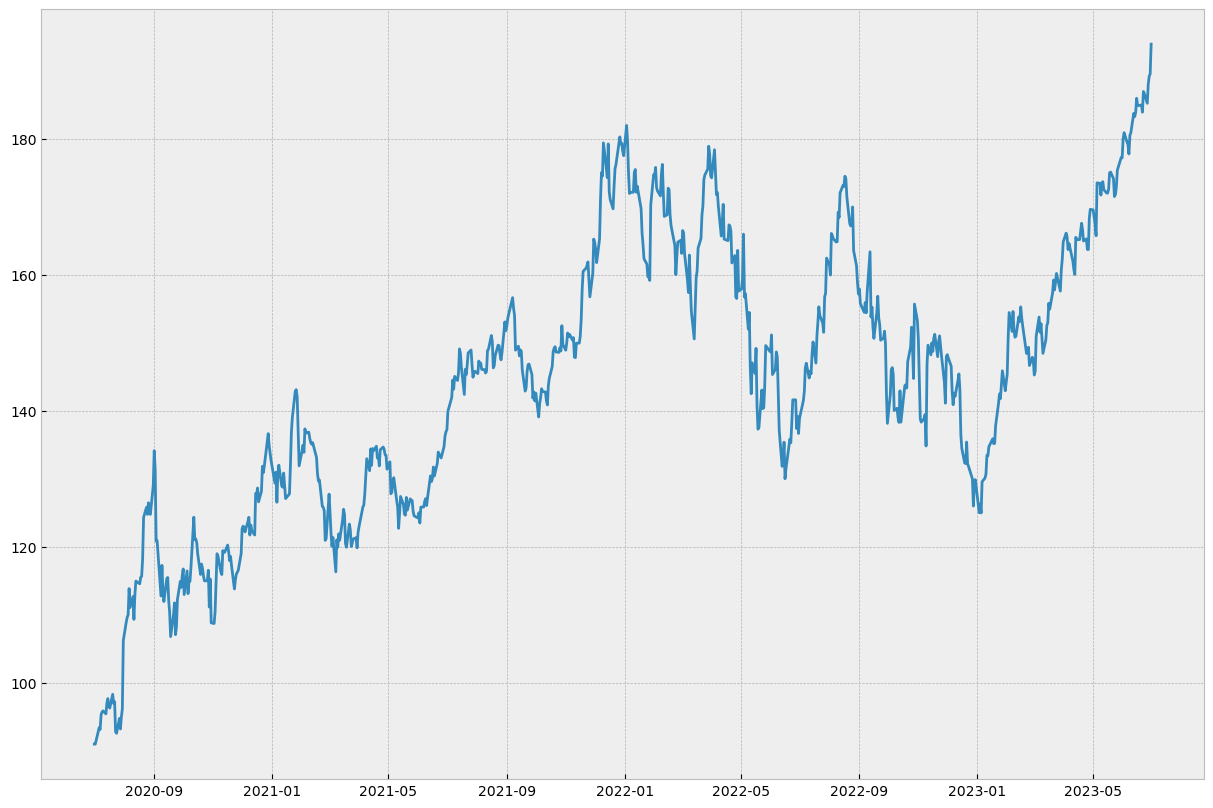

In [11]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

## 3. Zeitreihenanalyse

`seasonal_decompose` ist eine Funktion, die eine Zeitreihe in drei verschiedene Komponenten zerlegt:

- Trend: Die zugrundeliegende Tendenz der Zeitreihen. Dabei werden steigende und fallende Tendenzen abgebildet.
- Saisonalität: Periodische Schwankungen. Zum Beispiel könnte der Aktienkurs tendenziell während bestimmter Zeiten eines Jahres steigen oder fallen.
- Residual: Der Teil der Zeitreihe, der nicht durch Trend und Saisonalität erklärt werden kann.

Folgende Parameter werden verwendet:

- `data["Close"]`: Die zu analysierende Zeitreihe der Close-Werte
- `model='multiplicative'`: Das zu verwendende Modell für die Zerlegung. Ein multiplikatives Modell ist geeignet, wenn die Amplitude der saisonalen Schwankungen mit der Zeit zunimmt oder abnimmt.
- `period=30`: Die Länge des saisonalen Zyklus. In diesem Fall wird davon ausgegangen, dass sich die saisonalen Schwankungen alle 30 Tage wiederholen.

<Figure size 640x480 with 0 Axes>

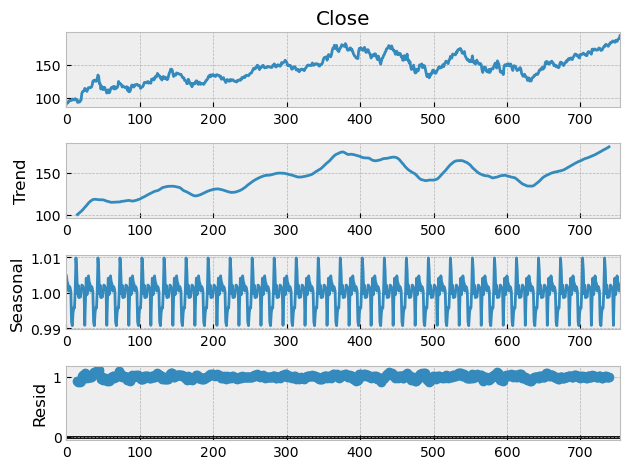

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot() 

In diesem Beispiel wird der Augmented Dickey-Fuller-Test auf die Werte in der Spalte "Close" angewendet. Die Ergebnisse des Tests werden ausgegeben, einschließlich der ADF-Statistik, des P-Werts und der kritischen Werte. Der P-Wert gibt an, ob die Nullhypothese der Nicht-Stationarität abgelehnt werden kann. Wenn der P-Wert kleiner als ein bestimmtes Signifikanzniveau (z. B. 0,05) ist, kann die Nullhypothese abgelehnt werden, und die Zeitreihe wird als stationär angesehen. Andernfalls kann die Nullhypothese nicht abgelehnt werden, und die Zeitreihe wird als nicht-stationär betrachtet.

In [13]:
from statsmodels.tsa.stattools import adfuller

# Annahme: data enthält die gewünschten Daten

# Die Spalte "Close" enthält die Werte, die auf Stationarität überprüft werden sollen
close_values = data["Close"]

# Augmented Dickey-Fuller-Test durchführen
result = adfuller(close_values)

# Ergebnisse ausgeben
print("Augmented Dickey-Fuller Test:")
print(f"ADF-Statistik: {result[0]}")
print(f"P-Wert: {result[1]}")
print("Kritische Werte:")
for key, value in result[4].items():
    print(f"  {key}: {value}")


Augmented Dickey-Fuller Test:
ADF-Statistik: -1.9795345263331257
P-Wert: 0.2956179531816448
Kritische Werte:
  1%: -3.439052522969989
  5%: -2.8653808299915013
  10%: -2.5688152592363274


In [29]:
# Differenzieren der Zeitreihe
differenced_values = close_values.diff().dropna()

In [33]:
from statsmodels.tsa.stattools import adfuller

# Annahme: differenced_values enthält die zweite differenzierte Zeitreihe

# Augmented Dickey-Fuller-Test für die differenzierte Zeitreihe durchführen
result = adfuller(differenced_values)

# Ergebnisse ausgeben
print("Augmented Dickey-Fuller Test für differenzierte Zeitreihe:")
print(f"ADF-Statistik: {result[0]}")
print(f"P-Wert: {result[1]}")
print("Kritische Werte:")
for key, value in result[4].items():
    print(f"  {key}: {value}")


Augmented Dickey-Fuller Test für differenzierte Zeitreihe:
ADF-Statistik: -11.452693595140868
P-Wert: 5.806082165654638e-21
Kritische Werte:
  1%: -3.4392782790913206
  5%: -2.865480319267325
  10%: -2.568868260909806


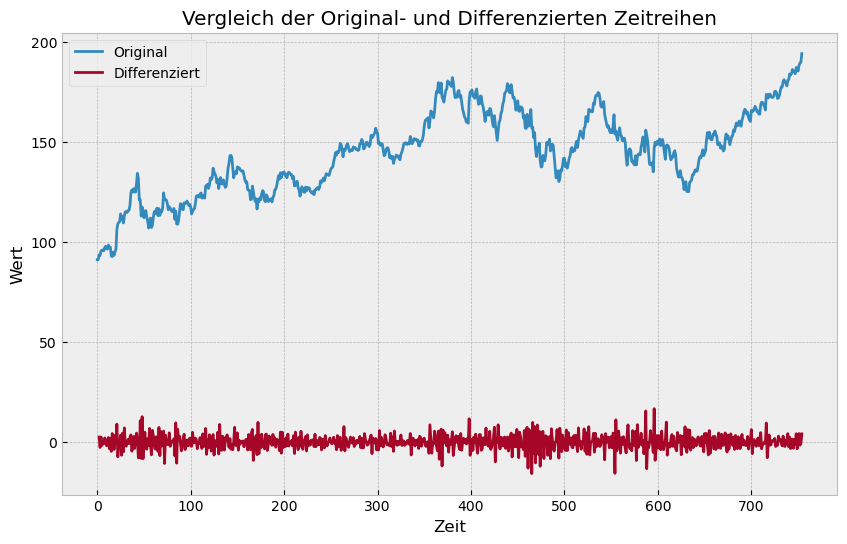

In [34]:
import matplotlib.pyplot as plt

# Annahme: close_values enthält die Original-Zeitreihe
# Annahme: differenced_values enthält die zweite differenzierte Zeitreihe

plt.figure(figsize=(10, 6))
plt.plot(close_values, label='Original')
plt.plot(differenced_values, label='Differenziert')
plt.xlabel('Zeit')
plt.ylabel('Wert')
plt.title('Vergleich der Original- und Differenzierten Zeitreihen')
plt.legend()
plt.show()


Die Interpretation der Autokorrelationsfunktion (ACF) und der Partial-Autokorrelationsfunktion (PACF) kann helfen, Muster und Abhängigkeiten in den Daten zu verstehen und geeignete Modelle für die Zeitreihenvorhersage auszuwählen.

Bei der Interpretation der ACF und PACF solltest du auf Folgendes achten:

Autokorrelationsfunktion (ACF):
- Signifikante Korrelation bei Lag 0: Wenn der Autokorrelationskoeffizient bei Lag 0 (also die Korrelation eines Wertes mit sich selbst) signifikant von Null abweicht, deutet dies auf eine starke Auto-Korrelation hin. Es könnte ein saisonales Muster in den Daten vorhanden sein.
- Abfallende Korrelation: Eine allmähliche Abnahme der Korrelationskoeffizienten über die Lags hinweg deutet darauf hin, dass vergangene Werte eine gewisse Vorhersagekraft für zukünftige Werte haben. Wenn die Korrelationen schnell abnehmen, kann dies auf ein exponentielles Glättungsmodell oder ein autoregressives Modell (AR-Modell) hinweisen.
- Signifikante Korrelationen bei bestimmten Lags: Das Auftreten von signifikanten Korrelationen bei bestimmten Lags kann auf saisonale Muster oder bestimmte autoregressive Komponenten hinweisen. Zum Beispiel könnten signifikante Korrelationen bei den Lags 1, 2 und 3 auf ein AR(3)-Modell hinweisen.

Partial-Autokorrelationsfunktion (PACF):
- Signifikante Korrelation bei Lag 0: Ähnlich wie bei der ACF ist eine signifikante Korrelation bei Lag 0 bedeutsam und kann auf saisonale Muster oder andere Abhängigkeiten hinweisen.
- Signifikante Korrelation nur bei bestimmten Lags: Die PACF ermöglicht es, die direkte Beziehung zwischen einem Lag und dem aktuellen Wert zu betrachten, während die Einflüsse früherer Lags herausgefiltert werden. Signifikante Korrelationen bei bestimmten Lags können auf autoregressive Komponenten des Modells hinweisen. Zum Beispiel könnte eine signifikante Korrelation bei Lag 1 auf ein AR(1)-Modell hinweisen.
- Abklingende Korrelation: Ähnlich wie bei der ACF kann eine allmähliche Abnahme der Korrelationskoeffizienten auf ein geeignetes Modell hinweisen.

Es ist wichtig zu beachten, dass die Interpretation der ACF und PACF als Leitfaden für die Modellauswahl dienen soll. Andere Faktoren wie Fachwissen, die Charakteristika der Daten und die Anpassung von Modellannahmen sind ebenfalls relevant. Es kann hilfreich sein, verschiedene Modellansätze auszuprobieren und die Ergebnisse zu vergleichen, um die bestmögliche Modellierung der Daten zu erzielen.

<Figure size 1000x600 with 0 Axes>

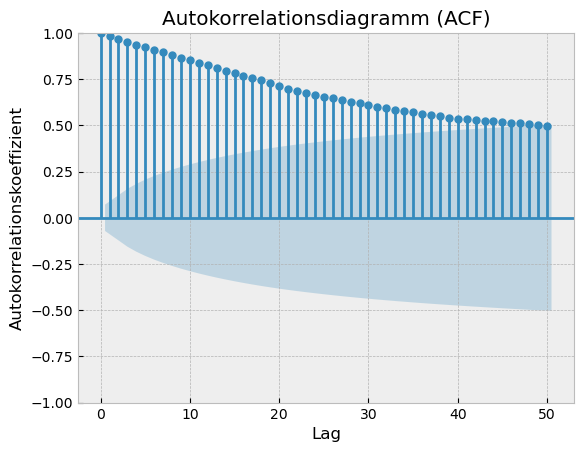

<Figure size 1000x600 with 0 Axes>

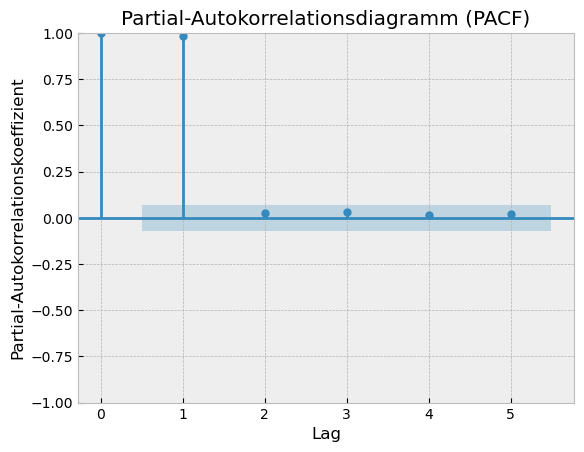

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Annahme: data enthält die gewünschten Daten

# Die Spalte "Close" enthält die Werte, für die das ACF und PACF geplottet werden sollen
close_values = data["Close"]

# Autokorrelationsdiagramm (ACF) plotten
plt.figure(figsize=(10, 6))
plot_acf(close_values, lags=50)
plt.title("Autokorrelationsdiagramm (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autokorrelationskoeffizient")
plt.show()

# Partial-Autokorrelationsdiagramm (PACF) plotten
plt.figure(figsize=(10, 6))
plot_pacf(close_values, lags=5)
plt.title("Partial-Autokorrelationsdiagramm (PACF)")
plt.xlabel("Lag")
plt.ylabel("Partial-Autokorrelationskoeffizient")
plt.show()


Die Funktion `pd.plotting.autocorrelation_plot()` ist eine visuelle Hilfsmethode, um die Autokorrelation in einer Zeitreihe darzustellen. Autokorrelation, auch bekannt als serielle Korrelation, bezeichnet die Korrelation eines Elements in einer Serie mit anderen Elementen aus derselben Serie, die von früheren Zeitschritten stammen.

Das Autokorrelationsdiagramm hilft zu erkennen, ob es eine Muster oder eine Beziehung zwischen den Werten einer Zeitspanne gibt und den Werten aus vorherigen Zeitspannen.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

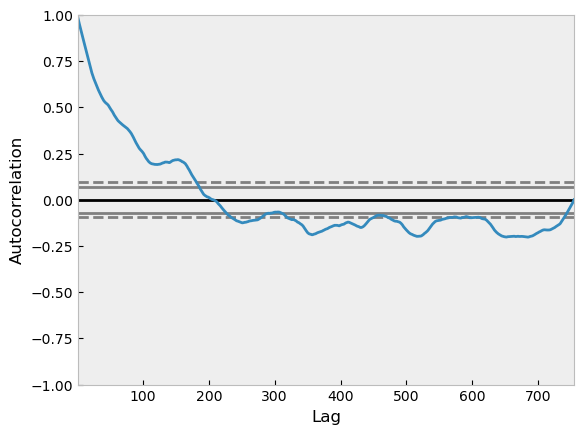

In [24]:
pd.plotting.autocorrelation_plot(data["Close"])

Die Funktion `plot_pacf` aus der `statsmodels.graphics.tsaplots` Bibliothek wird verwendet, um das partielle Autokorrelationsdiagramm für die gegebenen Zeitreihendaten zu erstellen. 

Ein Diagramm der partiellen Autokorrelation gibt Auskunft über die direkte Beziehung eines gegebenen Lags mit der aktuellen Zeitspanne, nachdem die Effekte aller kleineren Lags herausgerechnet wurden. 

Hier sind die Parameter, die in der Funktion verwendet werden:

- `data["Close"]`: Die zu analysierende Zeitreihe (in diesem Fall die Schlusskurse der Aktien).
- `lags=100`: Die Anzahl der Lags, die im Diagramm angezeigt werden sollen. Ein Lag ist eine zeitliche Verzögerung.
- `method='ywm'`: Die Methode zur Schätzung der partiellen Autokorrelation. 'ywm' steht für die Yule-Walker-Gleichungen mit Modifikationen entsprechend der Methode von Levinson-Durbin.

Insgesamt zeigt dieser Codeabschnitt ein Diagramm, das die partielle Autokorrelation der Schlusskurse über 100 Lags hinweg darstellt. Diese Art von Diagramm kann nützlich sein, um die Anzahl der Lags zu bestimmen, die in einem autoregressiven Prognosemodell verwendet werden sollten.

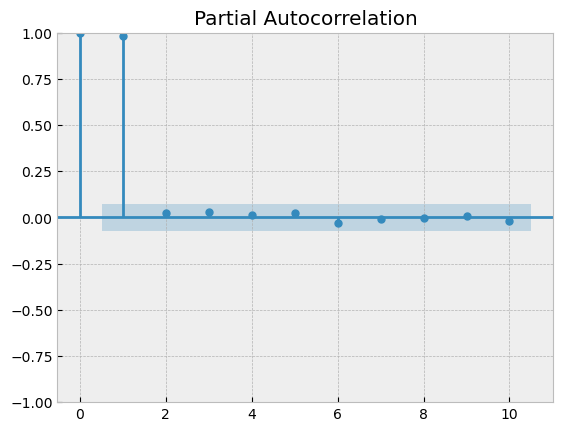

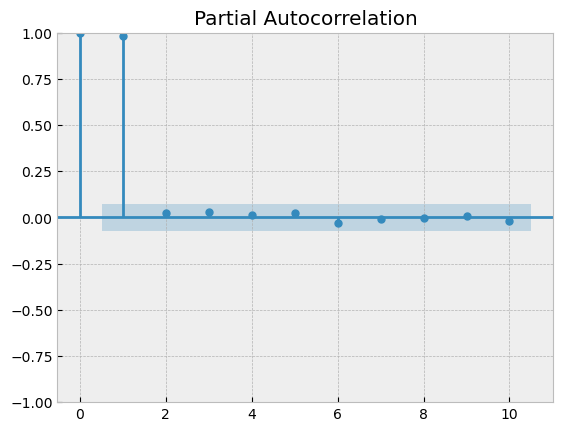

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags=10, method='ywm')

## 4. Modellbildung und -anpassung

ARIMA ist ein gebräuchlicher Algorithmus für die Vorhersage von Zeitreihen. Er basiert auf drei zentralen Parametern:

- `p` steht für die Anzahl der zurückliegenden Datenpunkte, die berücksichtigt werden, um den nächsten Punkt zu prognostizieren. Dies ist der autoregressive Aspekt des Modells.
- `d` repräsentiert die notwendigen Differenzbildungen, um die Zeitreihe stationär zu machen. Dies ist der integrierte Aspekt des Modells.
- `q` bezieht sich auf die Anzahl der vorhergehenden Fehler, die in das Modell einfließen. Dies ist der gleitende Durchschnittsaspekt des Modells.

In der Funktion `auto_arima` wird das 'Close'-Feld aus unseren Börsendaten als eindimensionales Array übergeben. Die Funktion probiert verschiedene Kombinationen von `p`, `d` und `q` aus und wählt diejenige aus, die das beste Modell ergibt (das heißt, das Modell mit dem niedrigsten AIC-Wert).

Die Einstellung `seasonal=False` teilt dem Modell mit, dass es keine saisonalen Komponenten berücksichtigen soll, während `trace=True` bewirkt, dass der Fortschritt der Funktion während der Ausführung angezeigt wird.

Zum Schluss werden die optimalen Werte für `p`, `d` und `q` ausgegeben und in den entsprechenden Variablen gespeichert.

In [6]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima

# Annahme: Sie haben Ihre Zeitreihendaten in einem DataFrame namens 'data' geladen

# Die Zeitreihendaten in eine eindimensionale NumPy-Array-ähnliche Struktur umwandeln
y = np.array(data['Close'])

# AutoARIMA-Modell erstellen und anpassen, um die optimalen Parameterwerte zu ermitteln
model = auto_arima(y, seasonal=False, trace=True)

# Die optimalen Parameterwerte für P, D und Q ausgeben
print(f"Optimale Werte für P, D und Q: {model.order}")
p, d, q = model.order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3684.646, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3680.060, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3681.619, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3681.572, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3679.890, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3682.912, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.560 seconds
Optimale Werte für P, D und Q: (0, 1, 0)


Es wurden verschiedene Kombinationen von P, D und Q getestet und dabei jeweils den AIC (Akaike Information Criterion) berechnet. Die AIC ist eine Maßzahl für die Güte eines statistischen Modells: Je kleiner der AIC-Wert, desto besser passt das Modell zu den Daten, wenn man die Komplexität des Modells mit einbezieht.

Im gegebenen Fall war das beste Modell ARIMA(0,1,0), weil es den niedrigsten AIC-Wert hatte (3679.890). Die optimalen Werte für P, D und Q waren also 0, 1 und 0. Dies bedeutet:

    P (Ordnung des autoregressiven Teils): 0 – Es werden keine vorherigen Datenpunkte zur Vorhersage des nächsten Punktes verwendet.
    D (Integrationsgrad): 1 – Die Zeitreihe wurde einmal differenziert, um sie stationär zu machen.
    Q (Ordnung des gleitenden Durchschnitts): 0 – Es werden keine vorherigen Fehler in das Modell einbezogen.

SARIMAX wird verwendet, um ein saisonales autoregressives, integriertes gleitendes Durchschnittsmodell (Seasonal AutoRegressive Integrated Moving Average, SARIMA) zu erstellen und an die Daten anzupassen. Dies ist eine Erweiterung des ARIMA-Modells, das die saisonale Komponente in den Daten berücksichtigt.

Es werden 4 Parameter übernommen: die Zeitreihendaten, die Ordnung des Modells (p, d und q), und die saisonale Ordnung des Modells. Hier sind die Schlusskurse ('Close') aus den Aktiendaten die Zeitreihendaten und die durch auto_arima ermittelten optimalen Werte werden als Ordnung des Modells und der saisonalen Ordnung übergeben. Die Zahl 12 in der saisonalen Ordnung bedeutet, dass die Saisonalität auf jährlicher Basis betrachtet wird (12 Monate).

In [7]:
import statsmodels.api as sm
import warnings
import time

# Startzeit messen
start_time = time.time()

model = sm.tsa.statespace.SARIMAX(data['Close'],
                                 order=(p, d, q),
                                 seasonal_order=(p, d, q, 12))
model = model.fit()

# Endzeit messen
end_time = time.time()

# Gesamtdauer berechnen
duration = end_time - start_time

print(model.summary())
print("Durchlaufdauer:", duration, "Sekunden")

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  755
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2084.510
Date:                            Wed, 12 Jul 2023   AIC                           4171.019
Time:                                    14:16:00   BIC                           4175.629
Sample:                                         0   HQIC                          4172.796
                                            - 755                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        16.1315      0.702     22.973      0.000      14.755      17.508
Ljung-Box (L1) (Q):                

## 5. Vorhersagen

Es wird eine Vorhersage für die nächsten 30 Tage gemacht.

Zuerst werden zukünftige Daten generiert, indem ein `pd.date_range`-Objekt erstellt wird, das mit dem Tag nach dem letzten Datum in den Daten beginnt und für die nächsten 30 Tage andauert.

Ein neuer DataFrame `df_predictions` wird erstellt, der die zukünftigen Daten und die entsprechenden Vorhersagen enthält.

Dann wird dieser neue DataFrame an den ursprünglichen DataFrame angehängt, um einen erweiterten DataFrame `data_extended` zu erstellen, der sowohl die ursprünglichen Daten als auch die Vorhersagen enthält.

Anschließend wird ein Plot erstellt, der die Schlusskurse mit Datum abbildet. Die ursprüngliche Zeitreihe wird zusammen mit den Vorhersagen für die nächsten 30 Tage gezeichnet. 

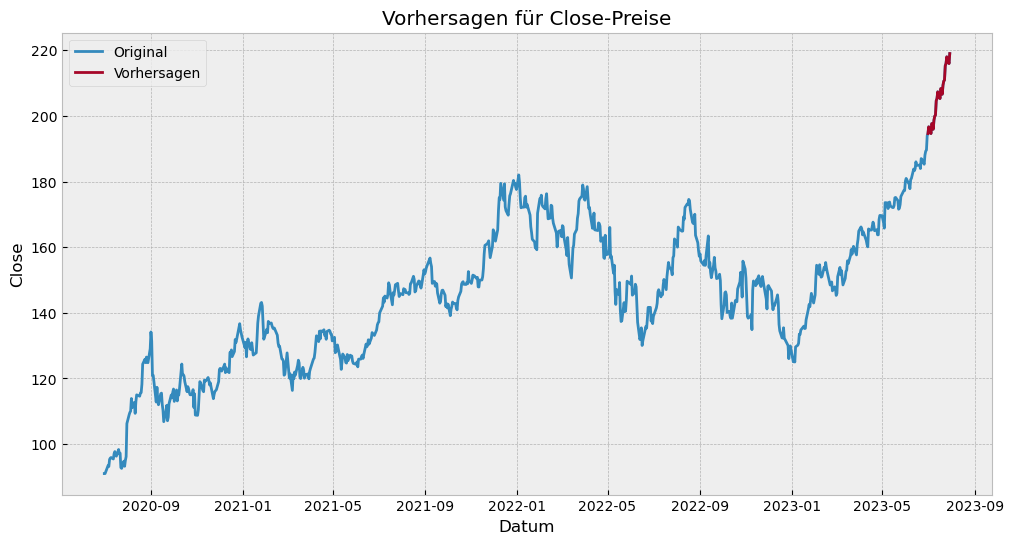

In [8]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

## 7. Datenbankaktualisierung

In nächsten Schritt werden neue Spalten zum `data_extended` DataFrame hinzugefügt, um zusätzliche Informationen über das Unternehmen, den Datentyp und einen eindeutigen Schlüssel zu speichern.

Die 'Company' Spalte wird mit dem Unternehmensnamen gefüllt, der aus dem ursprünglichen DataFrame extrahiert wurde.

Die 'Type' Spalte wird erstellt, um zu unterscheiden, ob die Daten tatsächliche Daten ('Act_') oder Vorhersagedaten ('Arima_') sind. Die Funktion `apply` wird auf die 'High' Spalte angewendet und die Funktion `lambda` überprüft, ob der Wert `nan` ist. Wenn er `nan` ist (was bei den vorhergesagten Daten der Fall sein sollte, da nur die 'Close' Preise vorhergesagt wurden), wird 'Arima_' vorangestellt. Ansonsten wird 'Act_' vorangestellt. Anschließend wird der Unternehmensname angehängt.

Die 'Forecast_Date' Spalte wird mit dem Wert von `end_date` gefüllt, aber nur für die Zeilen, in denen 'Type' 'Arima_' enthält, was bedeutet, dass es sich um Vorhersagedaten handelt.

Schließlich wird eine 'Key' Spalte erstellt, die eine Kombination aus 'Company', 'Date' und 'Type' ist. Diese dient als eindeutiger Identifikator für jede Zeile.

Diese Spalten werden hinzugefügt, um zusätzliche Informationen zu speichern und die Datenorganisation und -zugriff zu erleichtern.

In [9]:
import numpy as np

# Key einbinden
company = data.loc[0]['Company']
data_extended['Company'] = company
data_extended['Type'] = data_extended['High'].apply(lambda x: f'Arima_{company}' if np.isnan(x) else f'Act_{company}')
data_extended.loc[data_extended['Type'].str.contains('Arima'), 'Forecast_Date'] = end_date
data_extended['Key'] = data_extended['Company'] + '_' + data_extended['Date'].astype(str) + '_' + data_extended['Type']


Es wird eine Verbindung zu einer SQL Server Datenbank hergestellt und die Daten aus der Tabelle `stock_data_forecast` in einen DataFrame geladen. Außerdem wird eine neue Spalte 'Key' zu diesem DataFrame hinzugefügt, die einen eindeutigen Identifikator für jede Zeile darstellt.

Zuerst werden die notwendigen Bibliotheken importiert und die Pandas-Warnungen deaktiviert, um den Code sauberer aussehen zu lassen.

Ein Verbindungsstring zur Datenbank wird erstellt und eine Verbindung zur Datenbank hergestellt. Mit der `create_engine` Funktion von SQLAlchemy wird ein 'connectable' erstellt, das mit der pyodbc-Verbindung arbeitet.

Dann wird eine SQL-Abfrage definiert, um alle Daten aus der Tabelle `stock_data_forecast` zu holen, die gleich benötigt wird. Das Ergebnis wird in ein DataFrame `exists_df` geladen.

Anschließend werden noch Angleichung durchgeführt.

In [10]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(data_extended.dtypes)
exists_df = exists_df.reindex(columns=data_extended.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

Im nächsten Schritt werden die Forecast-Daten mit den in der SQL-Datenbank enthaltenen Daten zusammengeführt und die Duplikate werden entfernt. Abschließend werden die übrigen Daten in die Datenbank geschrieben.

In [11]:
# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended])

# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 78 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.


In [12]:
# Darstellung der übertragenen Daten
combined_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Forecast_Date,Key
291,NaN,2023-06-02,AAPL,Arima_AAPL,NaN,NaN,NaN,180.089996,NaN,2023-06-01,AAPL_2023-06-02_Arima_AAPL
292,NaN,2023-06-03,AAPL,Arima_AAPL,NaN,NaN,NaN,180.709991,NaN,2023-06-01,AAPL_2023-06-03_Arima_AAPL
293,NaN,2023-06-04,AAPL,Arima_AAPL,NaN,NaN,NaN,183.069992,NaN,2023-06-01,AAPL_2023-06-04_Arima_AAPL
294,NaN,2023-06-05,AAPL,Arima_AAPL,NaN,NaN,NaN,183.179993,NaN,2023-06-01,AAPL_2023-06-05_Arima_AAPL
295,NaN,2023-06-06,AAPL,Arima_AAPL,NaN,NaN,NaN,182.219986,NaN,2023-06-01,AAPL_2023-06-06_Arima_AAPL
...,...,...,...,...,...,...,...,...,...,...,...
780,NaN,2023-07-26,AAPL,Arima_AAPL,NaN,NaN,NaN,217.990005,NaN,2023-07-01,AAPL_2023-07-26_Arima_AAPL
781,NaN,2023-07-27,AAPL,Arima_AAPL,NaN,NaN,NaN,216.900009,NaN,2023-07-01,AAPL_2023-07-27_Arima_AAPL
782,NaN,2023-07-28,AAPL,Arima_AAPL,NaN,NaN,NaN,216.990005,NaN,2023-07-01,AAPL_2023-07-28_Arima_AAPL
783,NaN,2023-07-29,AAPL,Arima_AAPL,NaN,NaN,NaN,215.940018,NaN,2023-07-01,AAPL_2023-07-29_Arima_AAPL
